# Finding Open Channels by using Anomaly Detection
As this is a somewhat nontraditional machine learning competition, it might be fun to look at the problem from a different perspective. <br>
Hence the idea of using anomaly detection to find open channels in those parts of the data which are binary (0 or 1 channels).

We will use a python package to perform anomaly detection called ADTK:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install adtk ;

     |████████████████████████████████| 61kB 1.8MB/s 


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from adtk.detector import GeneralizedESDTestAD
from adtk.visualization import plot
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data preprocessing
As I will only perform limited anomaly analysis, I restricted the data to the first batch (as I am sure only 0 and 1 open channels occur in this part of the data). <br>
Second, as anomaly detection takes into account the time between events, I added generated a timestamp value for each row based on the Time column.

In [0]:
df = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/train_clean.csv')
df = df.iloc[1000000:1500000]
df.time = [np.datetime64('2020-05-12') + pd.Timedelta(x, unit='ms') for x in df.time.values]
df.index = df.time

## Anomaly detection
ADTK provides multiple anomaly detection tools. Here I've used the GeneralizedESDTestAD and tuned the alpha parameter a bit. <br>
GeneralizedESDTestAD detects anomaly based on generalized [extreme Studentized deviate (ESD)](https://en.wikipedia.org/wiki/Grubbs%27s_test_for_outliers) test.

In [0]:
from adtk.detector import GeneralizedESDTestAD
esd_ad = GeneralizedESDTestAD(alpha=80)
anomalies = esd_ad.fit_detect(df.signal)

## Visualisation

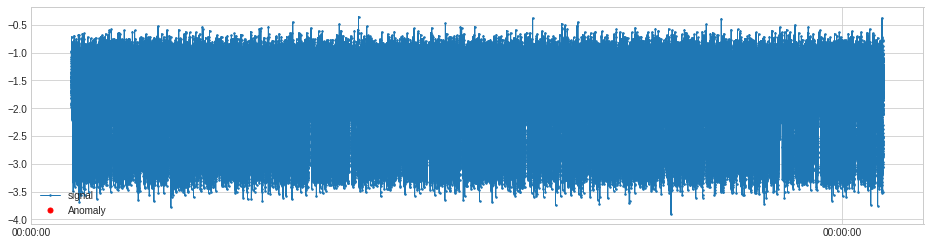

In [19]:
plot(df.signal, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

## Score

In [0]:
f1_score(df.open_channels, anomalies, average='macro')

0.9628654640266314

## Bonus: post-processing
By tweaking the results a little bit, such as smoothing the anomalies' outcome, the score can be improved even further.

In [0]:
def change(val, b, r):
    t = val.copy()
    for i in range(0,len(t),b):
        if np.sum(t[i:i+b])==b-1:
            t[i:i+b]=1
    for i in range(0,len(t),r//2):
        if np.sum(t[i:i+r])<2:
            t[i:i+r]=0
    return t

In [0]:
f1_score(df.open_channels, change(anomalies.values,5,250), average='macro')

0.9642759676044448